In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [84]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
torch.manual_seed(1337)


In [85]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
# chars = sorted(list(set(''.join(words))))
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
vocab_size = len(itos)
print(vocab_size)


65


In [86]:
#train 90% valid 10%
#train 1002854
#valid  111540
data = torch.tensor(encode(text), dtype=torch.long)
n =int(len(data)*0.9)
train_data = data[:n]
valid_data = data[n:]
print(train_data.shape)

torch.Size([1003854])


In [87]:
#data loading

def batch_generate(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(0, len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
    

In [88]:
class BigramLanguageModel(nn.Module):    
    def __init__(self, vocab_size):
        super().__init__()
        self.training = True
        self.emb = torch.nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        #(B,T) -> (B,T,C)
        logits = self.emb(idx)
        
        if self.training: 
            #Cross_entropy : (B, C ,T)
            B, T, C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None
            
        return logits, loss
        
    def generate(self, context, max_tokens):
        self.training = False
        # idx is (B, T) array of indices in the current context
        for _ in range(max_tokens):
            # get the predictions B,T -> B,T,C
            logits, loss = self(context)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1) # (B, C)
            sample_next = torch.multinomial(probs, num_samples=1)
            context = torch.cat((context, sample_next), dim=1) # (B, T+1)
        return context
            
            
        

model = BigramLanguageModel(vocab_size).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    

In [89]:
split = 'train' 
lossi = []

for iter in range(max_iters):
    
    #forward
    x, y = batch_generate(split)
    logits, loss = model(x,y)
    
    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f'loss: {loss}')
    lossi.append(loss.item())
    

loss: 4.648484230041504
loss: 4.641536235809326
loss: 4.691009998321533
loss: 4.682889461517334
loss: 4.666659832000732
loss: 4.627643585205078
loss: 4.633952617645264
loss: 4.713747024536133
loss: 4.633468151092529
loss: 4.726512432098389
loss: 4.639667510986328
loss: 4.580594539642334
loss: 4.645598411560059
loss: 4.57269811630249
loss: 4.634829044342041
loss: 4.505932331085205
loss: 4.48927116394043
loss: 4.645577907562256
loss: 4.525200366973877
loss: 4.590367794036865
loss: 4.44746208190918
loss: 4.468320369720459
loss: 4.4942216873168945
loss: 4.522458076477051
loss: 4.455782890319824
loss: 4.429958820343018
loss: 4.473094940185547
loss: 4.369729518890381
loss: 4.3797502517700195
loss: 4.35111665725708
loss: 4.495520114898682
loss: 4.358057498931885
loss: 4.4485039710998535
loss: 4.36574125289917
loss: 4.390077590942383
loss: 4.406174182891846
loss: 4.3189311027526855
loss: 4.285853385925293
loss: 4.388516426086426
loss: 4.300431728363037
loss: 4.2729058265686035
loss: 4.37363290

In [90]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_tokens=500)[0].tolist()))




CEThik brid owindakis s, ble

Hiset bube d e.
S:
O:3 my d?
LUCous:
Wanthar u qur, vet?
F dXENDoate awice my.

Hastarom orou wabuts, tof is h ble mil ndill, ath iree sengmin lat Heriliovets, and Win nghir.
Swanousel lind me l.
HAshe ce hiry:
Sugr aisspllwhy.
Hentous n Boopetelaves
MPOLI s, d mothakleo Windo whth eisbys wie m dourive we higend t so mower; te

AN ad nthrupt f s ar iris! m:

Thin inleronth,
Mad
RD:

WISo myrangoube!
KENob&y, wardsal thes ghesthidin couk ay aney Iry ts I&fr y ce wi


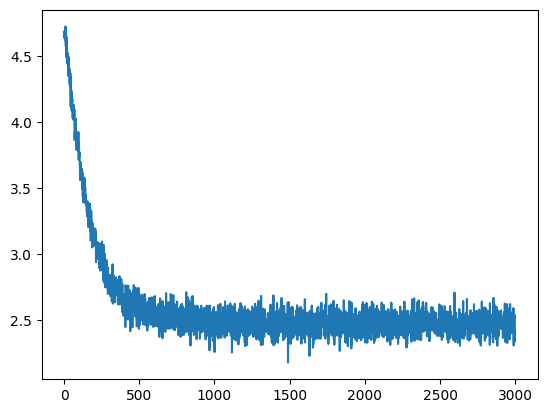

In [91]:
plt.plot(lossi)